# Object Tracking

In [1]:
import sys, os 
sys.path.append(os.path.dirname(os.getcwd()))
import seaborn as sns
sns.set()

In [2]:
from MontePython import monte_python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from skimage.measure import regionprops, regionprops_table
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["white", "red", "blue", "green", "purple", 'gray'])

In [3]:
def label_centroid(ax, object_props):
    """Place object label on object's centroid"""
    for region in object_props:
        x_cent,y_cent = region.centroid
        x_cent=int(x_cent)
        y_cent=int(y_cent)
        xx, yy = x[x_cent,y_cent], y[x_cent,y_cent]
        fontsize = 6.5 if region.label >= 10 else 8
        ax.text(xx,yy,
                    region.label,
                    fontsize=fontsize,
                    ha='center',
                    va='center',
                    color = 'k'
                    )

In [4]:
# Create fake storm data
fig=plt.figure(figsize=(10, 8), dpi= 300, facecolor='w', edgecolor='k')

g_len = 115
grid = np.zeros((g_len, g_len))

x, y = np.meshgrid(np.arange(g_len), np.arange(g_len))
coords = np.dstack((x, y))

peak1_t0 = 1e4 * multivariate_normal(mean=[20, 38], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak2_t0 = 1e4 * multivariate_normal(mean=[45, 70], cov=np.array([[40, 20], [20, 20]])).pdf(coords)

def update_pos(i):
    grid = np.zeros((g_len, g_len))
    
    ii = 10 + (2.0*i)
    ij = 28 + (0.5*i)
    
    ji = 35 + (1.75*i)
    jj = 55 + (-0.3*i)
    
    peak1_t0 = 1e4 * multivariate_normal(mean=[ii, ij], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
    peak2_t0 = 1e4 * multivariate_normal(mean=[ji, jj], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
    
    if i < 5:
        grid +=  peak1_t0+peak2_t0
    
    else:
        x = 5 + (2.7*(i-5))
        y = 5 + (2.0*(i-5))
        peak3_t0 = 1e4 * multivariate_normal(mean=[x, y], cov=np.array([[42, 20], [20, 20]])).pdf(coords)
    
        grid +=  peak1_t0+peak2_t0+peak3_t0 
    
    return grid

#z = update_pos(i:=10)
#plt.pcolormesh(x, y, np.ma.array(z, mask=z < 10), cmap='jet', )
#plt.colorbar()

<Figure size 3000x2400 with 0 Axes>

In [5]:
param_set = [ {'min_thresh':30,
                                 'max_thresh':80,
                                 'data_increment':20,
                                 'area_threshold': 200,
                                 'dist_btw_objects': 50} , 
            
              {'min_thresh':35,
                                 'max_thresh':80,
                                 'data_increment':1,
                                 'area_threshold': 10,
                                 'dist_btw_objects': 5} 
            ]

params = {'params': param_set }

label_set = []
props_set = []
z_set = []
for i in range(50):
    z = update_pos(i)
    input_data = np.where(z > 10, z, 0)
    storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = params,  
                       )
    label_set.append(storm_labels)
    props_set.append(object_props)
    z_set.append(z)

In [6]:
tracker = monte_python.ObjectTracker(percent_overlap=0.2, mend_tracks=True)
tracked_objects = tracker.track(label_set)
object_props = [regionprops(tracks, data) for tracks, data in zip(tracked_objects, z_set)]

x_cent, y_cent = tracker.get_track_path(tracked_objects)

In [7]:
def plot_track(ax, x_cent, y_cent, ind): 
    labels = x_cent.keys()
    for l in labels:
        xs,ys = x_cent[l], y_cent[l]
        ax.plot(xs[:ind], ys[:ind])

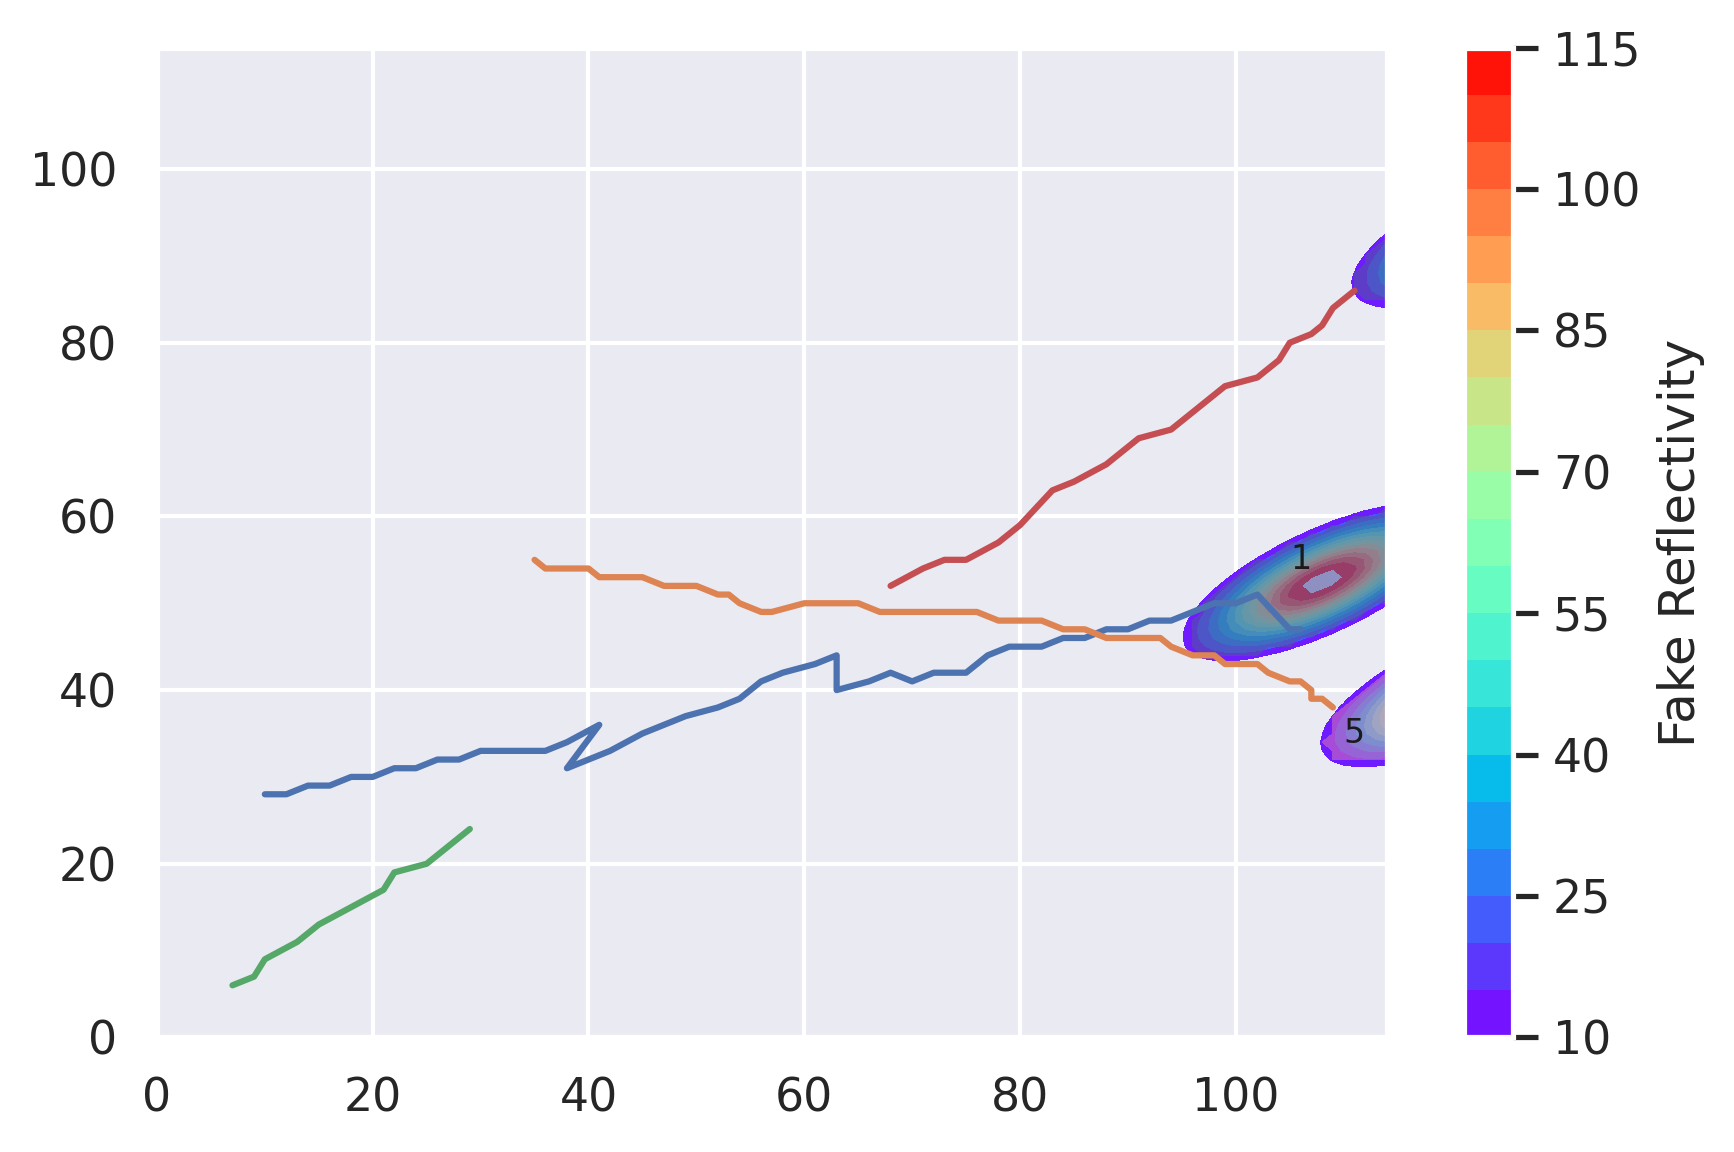

In [8]:
# Animate the Figure. 
fig, ax = plt.subplots(dpi=300)

cont = ax.contourf(x,y, np.ma.masked_where(z_set[0]==0, z_set[0]),
                   cmap='rainbow', levels=np.arange(10, 120, 5), )

ax.contourf(x,y, np.ma.masked_where(tracked_objects[0]==0, tracked_objects[0]), cmap = 'tab20b', alpha=0.6)
plot_track(ax, y_cent, x_cent, 0)
label_centroid(ax, object_props[0])
fig.colorbar(cont, label='Fake Reflectivity')

def animate(i):
    global cont
    z = z_set[i]
    tracks = tracked_objects[i,:,:]
    props = object_props[i]
    ax.clear()
    cont = ax.contourf(x,y,np.ma.masked_where(z==0, z), 
                       cmap='rainbow', levels=np.arange(10, 80, 5), )
    
    ax.contourf(x,y, np.ma.masked_where(tracks==0, tracks), cmap = 'tab20b', alpha=0.6)
    label_centroid(ax, props)
    plot_track(ax, y_cent, x_cent, i)
    return cont


# call the animator. blit=True means only re-draw the parts that have changed.
plt.tight_layout()
anim = FuncAnimation(fig, animate, frames=len(z_set), interval=40, repeat=True, blit=False)
HTML(anim.to_jshtml())
#anim.save(f'tune_object_{date}.gif', writer='pillow', fps=10)

In [9]:
tracker.trackprops

labels  duration  length
0       1        50     393
1       2        47     155
2       3        11      88
3       4        21     179
4       5         1       0